<a href="https://www.kaggle.com/code/samithsachidanandan/ambulance-detection-cnn?scriptVersionId=290948330" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [12]:
!pip install protobuf==3.20.3

In [13]:
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Config

In [14]:
IMAGE_SIZE = 128
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 20
DATA_DIR ='/kaggle/input/ambulance-dataset/carsdataset'

# Loading the data

In [33]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle = True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 4749 files belonging to 2 classes.


In [34]:
class_names = dataset.class_names
class_names

['ambulance', 'noambulance']

In [35]:
len(dataset)

75

# Visualizing the samples

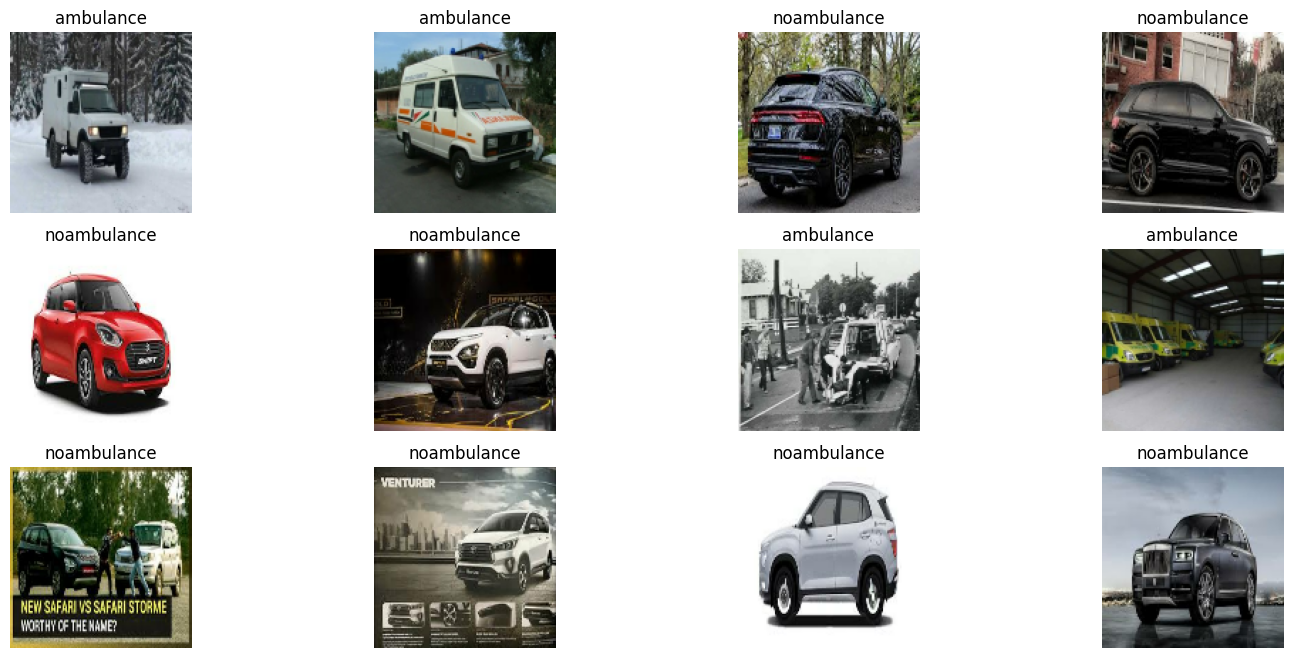

In [37]:
plt.figure(figsize=(18,8))
for image_batch, label_batch in dataset.take(1):

    num_images = min(12, len(image_batch)) 
    
    for i in range(num_images):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])   
        plt.axis('off')



# Train-Val-Test Split

In [38]:
def get_dataset_partitions_tf (ds,train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True,shuffle_size=10000 ):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds 

In [39]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [40]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Model

In [41]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=input_shape), 
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),   

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
   

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax'),
])


In [42]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,802 (471.88 KB)

 Trainable params: 120,034 (468.88 KB)

 Non-trainable params: 768 (3.00 KB)

In [43]:
model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics =['accuracy']
)

# Training

In [44]:
history= model.fit(
    train_ds, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1, 
    validation_data=val_ds
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.6936 - loss: 0.6767 - val_accuracy: 0.6591 - val_loss: 0.5322
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.9071 - loss: 0.2258 - val_accuracy: 0.5739 - val_loss: 0.6786
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9333 - loss: 0.1828 - val_accuracy: 0.8565 - val_loss: 0.2955
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9534 - loss: 0.1300 - val_accuracy: 0.8395 - val_loss: 0.3015
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9587 - loss: 0.1231 - val_accuracy: 0.7940 - val_loss: 0.4619
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9576 - loss: 0.1065 - val_accuracy: 0.8736 - val_loss: 0.2767
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9744 - loss: 0.0775 - val_accuracy: 0.9034 - val_loss: 0.2609
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9750 - loss: 0.0674 - val_accuracy: 0.9531 - v

In [45]:
scores = model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 574ms/step - accuracy: 0.9569 - loss: 0.0916


In [46]:
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Test Accuracy: 96.48%


# Plotting the result 

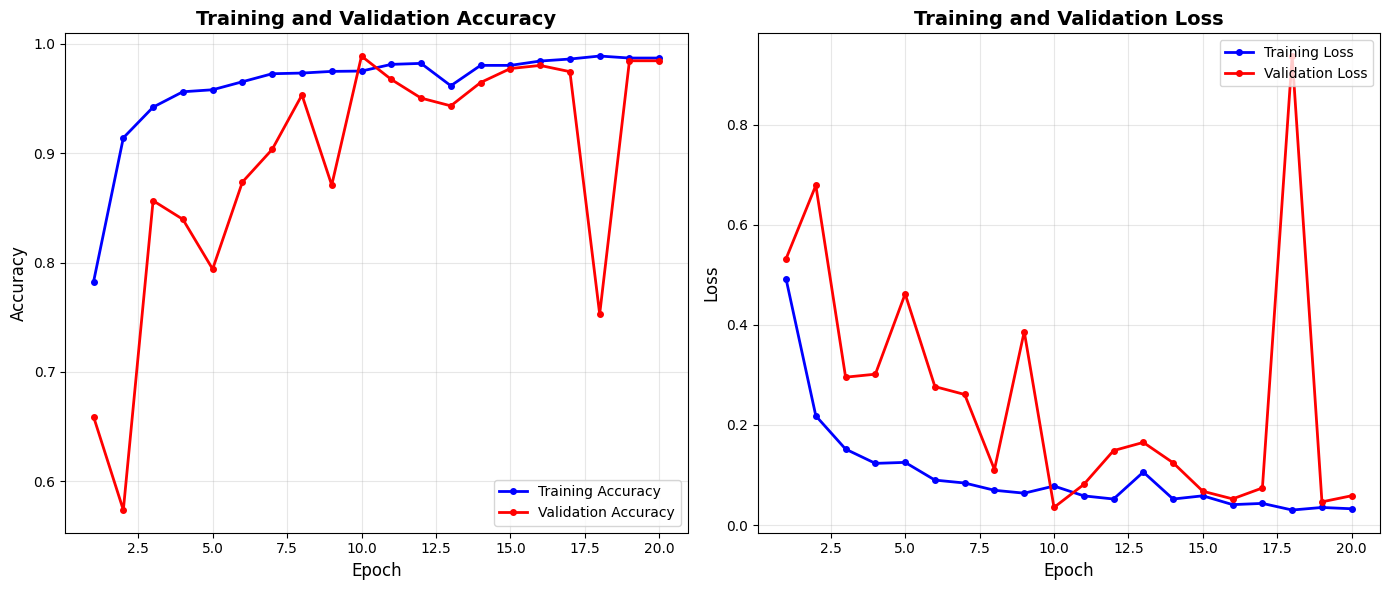


Training Summary:
Total epochs trained: 20
Best validation accuracy: 0.9886 (Epoch 10)
Final training accuracy: 0.9869
Final validation accuracy: 0.9844
Final training loss: 0.0326
Final validation loss: 0.0586



In [48]:
def plot_training_history(history):
    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
  
    total_epochs = len(acc)
    best_epoch = val_acc.index(max(val_acc)) + 1
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Total epochs trained: {total_epochs}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {best_epoch})")
    print(f"Final training accuracy: {acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final training loss: {loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"{'='*50}\n")



plot_training_history(history)


# Saving the Model 

In [49]:
model.save("ambulance_classifier.keras") 